### Torchtext BiDirectional LSTM (Packed Padded) with Custom Embedding  vectors

In this notebook we are going to create a `BiDirectionalLSTM` model to do emotional classification on text data. We are going to use the previous notebook as the base notebook to this one and modify few things. We are going to load a custom word embedding from our google colab with a name `glove.6B.100d.txt` which is a simple `txt` file which contains pretraned glove vectors.

### Reference Notebooks

The following notebooks are going to be used as refence in this notebook.

1. [11_%20Loading%2C_Saving_and_Freezing_Embeddings.ipynb](https://github.com/CrispenGari/pytorch-python/blob/main/09_NLP/02_Sentiment_Analyisis_Series/11_%20Loading%2C_Saving_and_Freezing_Embeddings.ipynb)
2. [01_Emotion_Prediction_From_Text.ipynb](https://github.com/CrispenGari/nlp-tensorflow/blob/main/03_Emotions/01_Emotion_Prediction_From_Text.ipynb)


###  Installation of Packages

In the following code cell we are going to install the packages that we are going to use in this notebook which are `helperfns` and `emoji`. The `emoji` package allows us to get emoji text and we will use it later on in this notebook. The `helperfns` package allows us to get some machine learning helper function which we are also going to use in this notebook as well.

In [2]:
!pip install helperfns -q

In [1]:
!pip install emoji -q

     |████████████████████████████████| 197 kB 27.4 MB/s 


### Imports 

In the following code cell we are going to import all the packages that are going to be used in this notebook.

In [3]:
import time
import emoji
import torch
import os
import random
import torchtext

from prettytable import PrettyTable
from matplotlib import pyplot as plt
from google.colab import drive
from torch import nn
from torchtext import data
from collections import Counter
from torchtext import vocab
from helperfns import tables, visualization, utils

import torch.nn.functional as F
import numpy as np
import pandas as pd

torchtext.__version__, torch.__version__

('0.13.1', '1.12.1+cu113')

### Files

Files are stored in google drive so we need to mount a google drive in our noteboook so that we can easily interact with the google file system using the `API`.

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


### File Paths
In the following code cell we are going to define the path where our files are going to be stored. We have the following filed `emotion-nlp`folder that is in our google drive:

1. train.csv
2. valid.csv
3. test.csv


We are also going to reference the path to our embending vectors file which is `glove.6B.100.txt` file. 

In [7]:
data_path = '/content/drive/MyDrive/NLP Data/emotions-nlp'
embedding_path = "/content/drive/MyDrive/NLP Data/glove.6B/glove.6B.100d.txt"

assert os.path.exists(data_path), f"The path '{data_path}' check if you mounted the google drive in this notebook."
assert os.path.exists(embedding_path), f"The path '{embedding_path}' check if you mounted the google drive in this notebook."

### Device
In the following code cell we are going to create a device variable and utilize the `cuda` GPU if available in this notebook.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Seed

In the following  code cell we are going to define the seed for reproducivity in this notebook.

In [9]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Reading the data
We are going to read the data in three files which are:

1. train.csv
2. test.csv
3. valid.csv

From our google drive files into pandas dataframes in the following code cell.

In [10]:
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))
val_df = pd.read_csv(os.path.join(data_path, 'valid.csv'))

### Checking Examples
In the following code cell we are going to check the first 5 example using the pandas dataframe method `head` for each dataframe.

In [11]:
train_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [12]:
test_df.head()

,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [13]:
val_df.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


#### Counting examples
In the following code cell we are going to count how many examples do we have in each set and visualize them in a tabular format.

In [14]:
columns = ["Set", "Example(s)"]
examples = [
    ['training', len(train_df)],
    ['validation', len(val_df)],
    ['testing', len(test_df)],
    ['total', len(train_df) +  len(test_df) + len(val_df)],
]
tables.tabulate_data(columns, examples, "Exmples")

+-------------------------+
|         Exmples         |
+------------+------------+
| Set        | Example(s) |
+------------+------------+
| training   |      16000 |
| validation |       2000 |
| testing    |       2000 |
| total      |      20000 |
+------------+------------+


### Features and Labels
Our fetures are the actual sentences in the dataframe which is the column named `text` and our labels will come from the column called `emotion`. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [15]:
# train
train_texts = train_df.text.values
train_labels = train_df.emotion.values

# test
test_texts = test_df.text.values
test_labels = test_df.emotion.values

# val
val_texts = val_df.text.values
val_labels = val_df.emotion.values

### Text Preprocessing
In our text processing pipeline we need to do the following step:

1. tokenize text 
- this is the process of converting a sentence or text into senquence of word. For this we are going to use a pre-trained model from `spacy` language model. You can read more about other tokenizers that you can use at [pytorch.org](https://pytorch.org/text/stable/data_utils.html).

2. vocabulary
* We will to create a vocabulary based on our text. A vocabulary is esentially a word to index mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.


#### Tokenizer

In the following code cell we are going to geta a tokenier object that will convert a sentence into a sequence of word using the `spacy-en` language model.

In [16]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')

tokenizer("This is a boy.")

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:106: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead'


['This', 'is', 'a', 'boy', '.']

#### Vocabulary
In the following code cell we are going to create a vocabulary object from  `torchtext`. This vocabulary takes in an `ordered_dict` of words to their count. So we are going to use the `Counter` module from collections to generate these counts from our train features.

We are going to specify the `min_freq` to `2` meaning that the words that does not appear at least 2 times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object. 

In [17]:
counter = Counter()
for line in train_texts:
    counter.update(tokenizer(line))
vocabulary = vocab.vocab(counter, min_freq=2, specials=('<unk>', '<sos>', '<eos>', '<pad>'))

### STOI - String To Integer
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called `stoi` which is essentially a dictionary of word to index mapping.

In [18]:
stoi = vocabulary.get_stoi()

### Text Pipeline

After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the `text_pipeline` function comes over. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay `stoi` will be habin an unkown (`<unk>`) index.

In [19]:
def text_pipeline(x: str):
  values = list()
  tokens = tokenizer(x.lower()) # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['<unk>']
    values.append(v)
  return values

### Label pipeline

Our labels for now are just emotional-words like `sad`. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a `labels_vocab` which is a label to integer representation. Which looks as follows:

```
{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}
```
The `label_pipeline` function will then takes in the label and then returns us an integer representation of that label.

In [20]:
labels_dict = dict({v: k for k, v in enumerate(train_df.emotion.unique())})
labels_dict

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}

In [21]:
label_pipeline = lambda x: labels_dict[x]

### Custom Word Embeddings
We are going to assume that `glove.6B.100d.txt` is our custom word embeddings file. This file looks like as follows:

```
the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 ....
is -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787
```
So first thing that we will do is to load each word in a dictionary of the word as the key and the vector as follows. Then we will create an embedding matrix that suits our data which is the one that we will load in the embedding layer.

In [22]:
embeddings_dictionary = dict()
with open(embedding_path, encoding='utf8') as glove_file:
  for line in glove_file:
    records = line.split()
    word  = records[0]
    vectors = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vectors

In [24]:
print(embeddings_dictionary['the'])

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

In [38]:
VOCAB_SIZE = len(stoi)
EMBEDDING_DIM = 100
EMBEDDING_MATRIX = torch.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, index in stoi.items():
  vector = embeddings_dictionary.get(word)
  if vector is not None:
    try:
      EMBEDDING_MATRIX[index] = torch.from_numpy(vector)
    except:
      pass

In [39]:
EMBEDDING_MATRIX

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.2265, -0.5235,  0.5280,  ..., -0.1423, -0.1669, -0.3038],
        [ 0.2190,  0.7244, -0.1162,  ...,  0.2099,  0.9361,  0.3596],
        [-0.2677,  0.5511, -0.0924,  ..., -0.5573, -0.5595,  0.1911]])

### Creating the EmotionDataset
In the following code cell we are going to create a dataset class called `EmotionDataset`. This dataset will takes in the `labels` and the `text` of a set.

In [28]:
class EmotionDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(EmotionDataset, self).__init__()
    self.labels = labels
    self.text = text
      
  def __getitem__(self, index):
    return self.labels[index], self.text[index]
  
  def __len__(self):
    return len(self.labels)

### collate_fn
We are going to create a collate function called `tokenize_batch`. This function acually takes in a batch and does the preprocessing of the text and labels. This function will be passed to the `DataLoader` class to do the preprocessing of features and labels.

`tokenize_batch` function:

* this function takes in a batch in each set and convert the features and labels to integer representation. It goes ahead and pad and truncate the sequence to the same length and returns `labels` and `features`.

In [29]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text.lower()), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch long tensors since it is a multi-class classification.
  return torch.LongTensor(labels_list), torch.cat(text_list, dim=0)

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `EmotionDataset` class.

In [30]:
train_dataset = EmotionDataset(train_labels, train_texts)
test_dataset = EmotionDataset(test_labels, test_texts)
val_dataset = EmotionDataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the `DataLoader` class from `torch.utils.data` for our `3` sets. We are going to use the `batch_size` of `128` and our `collate_function` is `tokenize_batch`. For the validation and testing dataset we are going to set the shuffle to `False` because there's no need fo us to shuffle these examples.

In [31]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

### Checking a single Batch Data

In [32]:
lbl, txt = iter(train_loader).next()

Labels in the first batch.

In [33]:
lbl

tensor([3, 1, 5, 5, 0, 5, 4, 4, 0, 1, 5, 0, 1, 4, 0, 5, 1, 0, 0, 0, 0, 5, 1, 1,
        0, 0, 0, 5, 5, 5, 1, 5, 1, 1, 1, 0, 5, 0, 0, 5, 5, 0, 4, 0, 0, 2, 5, 0,
        0, 3, 0, 5, 5, 3, 1, 4, 0, 5, 0, 2, 0, 0, 5, 1, 2, 0, 1, 0, 0, 4, 5, 0,
        3, 5, 5, 5, 2, 5, 5, 1, 0, 1, 0, 4, 0, 0, 3, 5, 5, 1, 2, 0, 0, 4, 5, 0,
        5, 5, 5, 2, 5, 0, 2, 0, 0, 0, 4, 0, 0, 5, 1, 5, 5, 0, 0, 4, 2, 5, 4, 5,
        5, 0, 1, 5, 0, 2, 0, 5])

The first sentence in the batch.

In [34]:
txt[0]

tensor([   4,  225,    7,   66,    4,  314, 6192,  649,  352,   25,   67, 3583,
         356,   29, 2287, 2090, 1451,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], dtype=torch.int32)

### Model Creation

Now that we have our loaders we can now create a model. The model that we are going to create is called `EmotionModel`. In the following code cell we are going to create our model.

In [35]:
class EmotionModel(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers
               , bidirectional, dropout, pad_idx):
    super(EmotionModel, self).__init__()

    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim=embedding_size, padding_idx=pad_idx),
        nn.Dropout(dropout)
    )
    self.lstm = nn.Sequential(
        nn.LSTM(
          embedding_size, 
          hidden_size=hidden_size, 
          bidirectional=bidirectional, 
          num_layers=num_layers,
          dropout=dropout
        )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=128),
        nn.Dropout(dropout),
        nn.Linear(128, out_features=output_size),
        nn.Dropout(dropout)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    # set batch_first=true since input shape has batch_size first and text_lengths to the device.
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
    packed_output, (h_0, c_0) = self.lstm(packed_embedded)
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    output = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim = 1)
    return self.out(output)

### Model Instance

In the following code cell we are going to create a model instance.

In [36]:
INPUT_DIM = len(stoi) 
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['<pad>'] 
emotions_model = EmotionModel(
              INPUT_DIM, 
              EMBEDDING_DIM, 
              HIDDEN_DIM, 
              OUTPUT_DIM, 
              N_LAYERS, 
              BIDIRECTIONAL, 
              DROPOUT, 
              PAD_IDX
).to(device)
emotions_model

EmotionModel(
  (embedding): Sequential(
    (0): Embedding(7364, 100, padding_idx=3)
    (1): Dropout(p=0.5, inplace=False)
  )
  (lstm): Sequential(
    (0): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=6, bias=True)
    (3): Dropout(p=0.5, inplace=False)
  )
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters.

In [37]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params, trainable_params = count_trainable_params(emotions_model)
print(f"Total number of paramaters: {n_params:,}\nTotal tainable parameters: {trainable_params:,}")

Total number of paramaters: 3,112,982
Total tainable parameters: 3,112,982


### Loading Embedding Vectors

In the following code cell we are going to load the pretained custom vectors in our embedding layer. We are going to load the embedding vectors tha suits our data using the `emotions_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)` as follows:

In [40]:
emotions_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.2265, -0.5235,  0.5280,  ..., -0.1423, -0.1669, -0.3038],
        [ 0.2190,  0.7244, -0.1162,  ...,  0.2099,  0.9361,  0.3596],
        [-0.2677,  0.5511, -0.0924,  ..., -0.5573, -0.5595,  0.1911]],
       device='cuda:0')

### Optimizer and Criterion

In the following code cell we are going to define the optimizer and criterion. For the optimizer we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `CrossEntropyLoss()` function since this is a multi-class classification.

In [41]:
optimizer = torch.optim.Adam(emotions_model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [42]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### Train and Evaluate functions

In the following code cell we are going to create our `train` and `evalutate` functions:

In [43]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop

In the following code cell we are going to run the training loop. We are going to save the model when the loss decreased.

In [44]:
N_EPOCHS = 10
MODEL_NAME = 'emotion-torch.pt'

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss, train_acc = train(emotions_model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(emotions_model, val_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(emotions_model.state_dict(), MODEL_NAME)
  end = time.time()
  data = [
       ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{utils.hms_string(end - start)}" ],
       ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],       
   ]
  columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
  tables.tabulate_data(columns, data, title)


+--------------------------------------------+
|     EPOCH: 01/10 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 1.659 |    0.318 | 0:00:11.36 |
| Validation | 1.439 |    0.519 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 02/10 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 1.496 |    0.382 | 0:00:10.00 |
| Validation | 1.150 |    0.620 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 03/10 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   

### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [45]:
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
emotions_model.load_state_dict(torch.load(MODEL_NAME))
test_loss, test_acc = evaluate(emotions_model, test_loader, criterion)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tables.tabulate_data(column_names, data_rows, title)

+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.148 |   93.06% |            |
+------+-------+----------+------------+


### Model Inference
In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [46]:
def inference_preprocess_text(text, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with <pad> = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

### Predicting Emotions
In the following code cell we are going to create a function that predicts the emotion in the text that is called `predict_emotion`.

In [47]:
emotions_emojis = {
   'anger' : ":angry:", 
   'fear': ":fearful:", 
   'joy' : ":smile:", 
   'love' : ":heart_eyes:", 
   'sadness' : ":disappointed:", 
   'surprise': ":open_mouth:"
}

In [48]:
def predict_emotion(model, sentence, min_len = 5):
  model.eval()
  with torch.no_grad():
    tensor = inference_preprocess_text(sentence).to(device)
    length = torch.tensor([len(t) for t in tensor])
    probabilities = torch.softmax(model(tensor, length).squeeze(0), dim=0)
    prediction = torch.argmax(probabilities)
    prediction = prediction.detach().cpu().item()
    classes = {v:k for k, v in labels_dict.items()}
    class_name = classes[prediction]
    columns_ =  ["label", 'value']
    title = "PREDICTIONS OF EMOTIONS"
    data = [
        ['text', sentence],
        ['predicted class', prediction],
        ['predicted class name', class_name],
        ['predicted emoji', emoji.emojize(emotions_emojis.get(class_name), language='alias')],
        ['probability', round(probabilities[prediction].item(), 2)]
    ]
    tables.tabulate_data(columns_, data, title)
  

In [49]:
# sadness
predict_emotion(emotions_model, "im updating my blog because i feel shitty.")

+-------------------------------------------------------------------+
|                      PREDICTIONS OF EMOTIONS                      |
+----------------------+--------------------------------------------+
| label                |                                      value |
+----------------------+--------------------------------------------+
| text                 | im updating my blog because i feel shitty. |
| predicted class      |                                          0 |
| predicted class name |                                    sadness |
| predicted emoji      |                                         😞 |
| probability          |                                        1.0 |
+----------------------+--------------------------------------------+


In [50]:
# fear
predict_emotion(emotions_model, "i am feeling apprehensive about it but also wildly excited")

+-----------------------------------------------------------------------------------+
|                              PREDICTIONS OF EMOTIONS                              |
+----------------------+------------------------------------------------------------+
| label                |                                                      value |
+----------------------+------------------------------------------------------------+
| text                 | i am feeling apprehensive about it but also wildly excited |
| predicted class      |                                                          4 |
| predicted class name |                                                       fear |
| predicted emoji      |                                                         😨 |
| probability          |                                                       0.99 |
+----------------------+------------------------------------------------------------+


In [51]:
# joy
predict_emotion(emotions_model, "i feel a little mellow today.")

+------------------------------------------------------+
|               PREDICTIONS OF EMOTIONS                |
+----------------------+-------------------------------+
| label                |                         value |
+----------------------+-------------------------------+
| text                 | i feel a little mellow today. |
| predicted class      |                             5 |
| predicted class name |                           joy |
| predicted emoji      |                            😄 |
| probability          |                           1.0 |
+----------------------+-------------------------------+


In [52]:
# surprise
predict_emotion(emotions_model, "i feel shocked and sad at the fact that there are so many sick people.")

+-----------------------------------------------------------------------------------------------+
|                                    PREDICTIONS OF EMOTIONS                                    |
+----------------------+------------------------------------------------------------------------+
| label                |                                                                  value |
+----------------------+------------------------------------------------------------------------+
| text                 | i feel shocked and sad at the fact that there are so many sick people. |
| predicted class      |                                                                      3 |
| predicted class name |                                                               surprise |
| predicted emoji      |                                                                     😮 |
| probability          |                                                                   0.91 |
+--------------------

In [53]:
# love 
predict_emotion(emotions_model, "i want each of you to feel my gentle embrace.")

+----------------------------------------------------------------------+
|                       PREDICTIONS OF EMOTIONS                        |
+----------------------+-----------------------------------------------+
| label                |                                         value |
+----------------------+-----------------------------------------------+
| text                 | i want each of you to feel my gentle embrace. |
| predicted class      |                                             2 |
| predicted class name |                                          love |
| predicted emoji      |                                            😍 |
| probability          |                                          0.98 |
+----------------------+-----------------------------------------------+


In [54]:
# anger
predict_emotion(emotions_model, "i feel like my irritable sensitive combination skin has finally met it s match.")

+--------------------------------------------------------------------------------------------------------+
|                                        PREDICTIONS OF EMOTIONS                                         |
+----------------------+---------------------------------------------------------------------------------+
| label                |                                                                           value |
+----------------------+---------------------------------------------------------------------------------+
| text                 | i feel like my irritable sensitive combination skin has finally met it s match. |
| predicted class      |                                                                               1 |
| predicted class name |                                                                           anger |
| predicted emoji      |                                                                              😠 |
| probability          |              

### Confusion matrix.

In the following code cell we are going to extract features and labels that we are going to use to plot our confusion matrix. We are going to use the `test` set.

In [55]:
test_features = []
test_labels = []
for (y, X) in test_loader:
  test_features.extend(X.numpy())
  test_labels.extend(y.numpy())
test_features = torch.tensor([i for i in test_features]).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [56]:
lengths = torch.tensor([len(i) for i in test_features])
emotions_model.eval()
with torch.no_grad():
  preds = torch.argmax(emotions_model(test_features, lengths), dim=1)
  preds = list(preds.detach().cpu().numpy())

In [57]:
classes = [k for k, v in labels_dict.items()]
classes

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

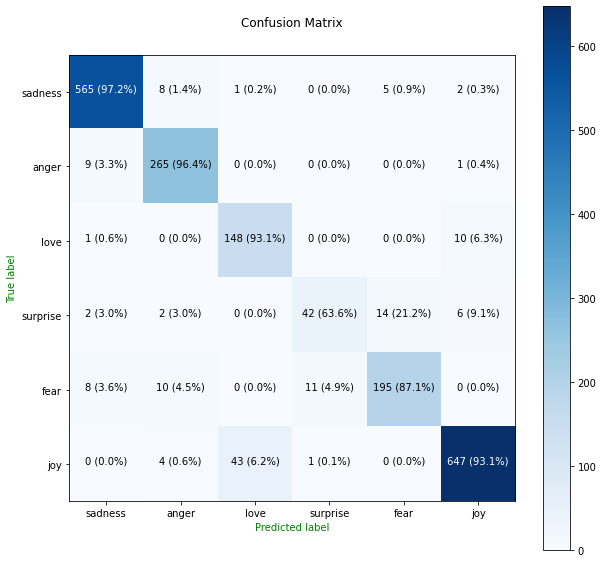

In [58]:
visualization.plot_complicated_confusion_matrix(test_labels, preds, classes, figsize=(10, 10), fontsize=10)